# **Building a Convolutional Neural Network (CNN)**

- 🌟[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

- 🌟[Deep Lizard](https://deeplizard.com/)

## LeNet -5 Architecture in pytorch

2.2.1+cu121
0.17.1+cu121
Number of classes: 10
Using device: cpu
LeNet5(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.60895 | Train acc: 48.98%
Test loss: 0.44816 | Test acc: 86.13%

Epoch: 1
--------
Train loss: 0.34061 | Train acc: 89.70%
Test loss: 0.25557 | Test acc: 91.99%

Epoch: 2
--------
Train loss: 0.22259 | Train acc: 93.16%
Test loss: 0.17125 | Test acc: 94.66%

Epoch: 3
--------
Train loss: 0.16252 | Train acc: 95.02%
Test loss: 0.12970 | Test acc: 96.13%

Epoch: 4
--------
Train loss: 0.12751 | Train acc: 96.06%
Test loss: 0.10473 | Test acc: 96.74%

Epoch: 5
--------
Train loss: 0.10579 | Train acc: 96.76%
Test loss: 0.09134 | Test acc: 96.97%

Epoch: 6
--------
Train loss: 0.09013 | Train acc: 97.26%
Test loss: 0.08181 | Test acc: 97.53%

Epoch: 7
--------
Train loss: 0.07948 | Train acc: 97.51%
Test loss: 0.08484 | Test acc: 97.46%

Epoch: 8
--------
Train loss: 0.07179 | Train acc: 97.75%
Test loss: 0.07691 | Test acc: 97.62%

Epoch: 9
--------
Train loss: 0.06626 | Train acc: 97.94%
Test loss: 0.06862 | Test acc: 97.72%

Train time on cpu: 338.101 sec

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'LeNet5', 'model_loss': 0.06861866265535355, 'model_acc': 97.72364217252397}




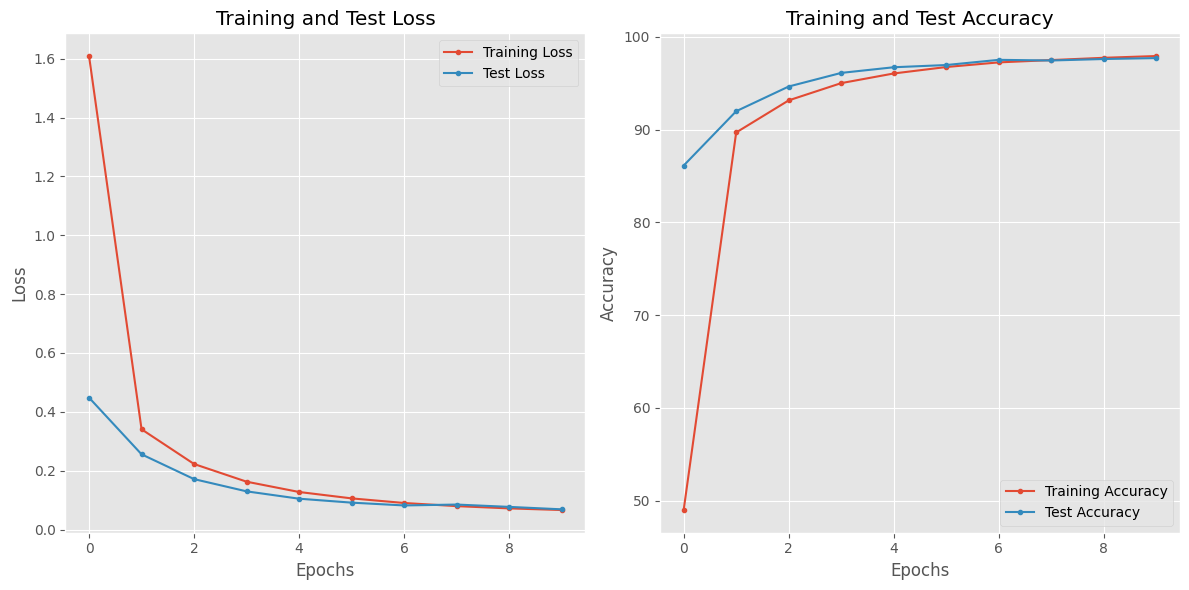

In [ ]:
# Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Check versions
print(torch.__version__)
print(torchvision.__version__)

# Set seed for reproducibility
torch.manual_seed(42)

# ------------------------------Datasets--------------------------------------
# MNIST dataset will be used instead of FashionMNIST for LeNet-5
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Get class names
class_names = train_data.classes
print(f"Number of classes: {len(class_names)}")

# ------------------------------DataLoader------------------------------------
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------------------MODEL-----------------------------------
# Define the LeNet-5 model architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), # C1
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),     # S2
            nn.Conv2d(6, 16, kernel_size=5),           # C3
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),     # S4
            nn.Conv2d(16, 120, kernel_size=5),         # C5
            nn.ReLU()
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(120, 84),                        # F6
            nn.ReLU(),
            nn.Linear(84, 10)                          # Output layer
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, 1) # Flatten the tensor
        x = self.linear_stack(x)
        return x

# Create an instance of the LeNet-5 model
model = LeNet5().to(device)
print(model)

# ------------------------------Loss and Optimizer-----------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Initialize lists to hold metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


# Functionizing training and evaluation/testing loops
### ------------------------------Training loop---------------------------------
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0

    # Put the model into training mode
    model.train()

    # looping through the training batches
    for batchs, (X, y) in enumerate(data_loader):
        # Put the data on the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass(output the raw logits from the model)
        y_pred = model(X)

        # 2. Calculate the loss and accuracy(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss  # accumulate train loss
        train_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(y_pred, dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

    # Return the loss and accuracy
    return train_loss.item(), train_acc


### ----------------------------Testing loop------------------------------------
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    test_loss, test_acc = 0, 0

    # Put the model in  eval mode
    model.eval()

    # Turn on the inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass(Output the raw logits)
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(test_pred, dim=1)) # go from logits -> prediction labels

        ## Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

    # Return the loss and accuracy
    return test_loss.item(), test_acc


### ---------------------------Evaluation loop----------------------------------

def print_train_time(start:float,
                     end: float,
                     device: torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Set epoch
epochs = 10

start_timer = timer() # <<<-start timer->>>

# Create the optimiztion and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")

    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                     data_loader=test_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                     device=device)

    # Append the values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

end_timer = timer() # <<<-End Timer->>>
total_train_time_model_1 = print_train_time(start=start_timer,
                                            end=end_timer,
                                            device=device)


### ------------------------------Predictions-----------------------------------
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_1_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
print(model_1_results)


### -------------------------------visualization-------------------------------
print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

  0%|          | 0/313 [00:00<?, ?it/s]

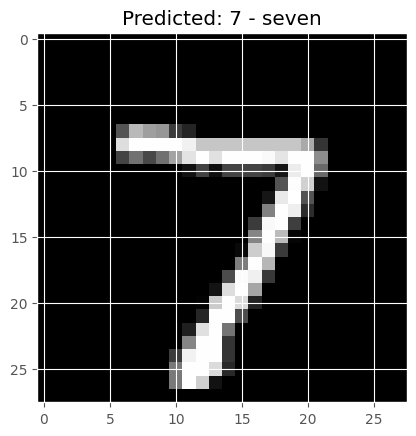

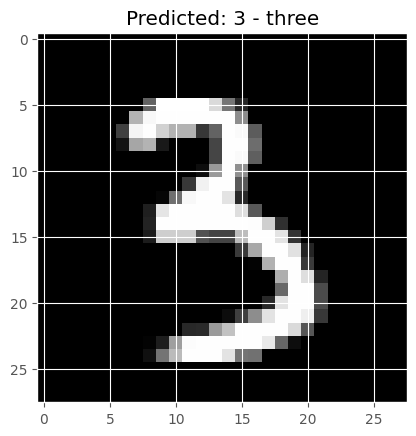

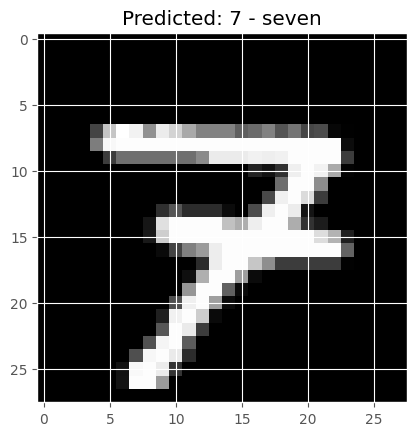

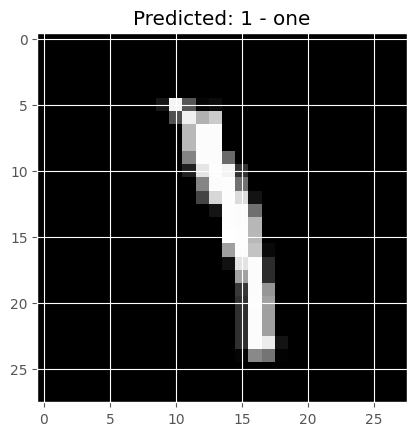

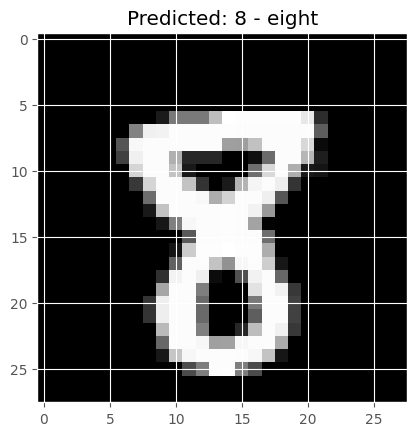

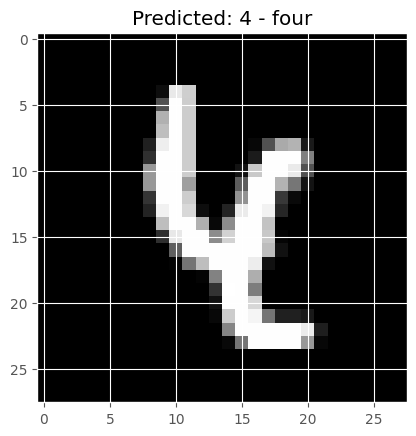

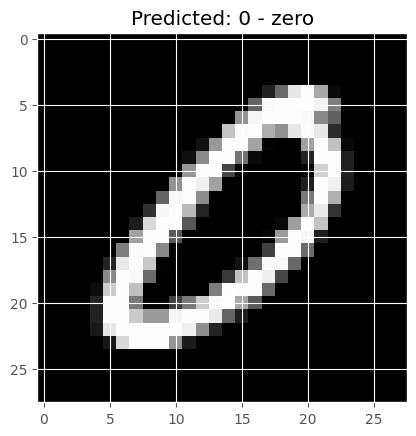

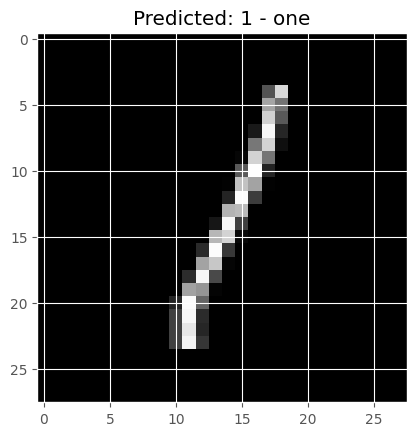

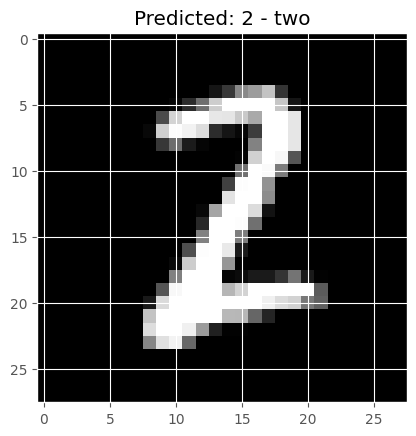

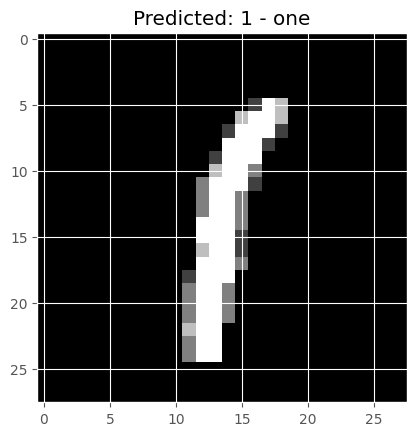

{'model_name': 'LeNet5', 'model_loss': 0.0011037873337045312, 'model_acc': 3.1749201277955272}


In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        # Initialize a counter
        counter = 0
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Visualize the first image in the batch with its prediction
            if counter < 10:  # Check if the counter is less than 10
                plt.imshow(X[0].cpu().squeeze(), cmap='gray')
                plt.title(f"Predicted: {class_names[y_pred[0].argmax(dim=0).item()]}")
                plt.show()
                counter += 1  # Increment the counter

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

            # Break the loop if 10 images have been visualized
            if counter >= 10:
                break

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Example usage
model_1_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
print(model_1_results)


  0%|          | 0/313 [00:00<?, ?it/s]

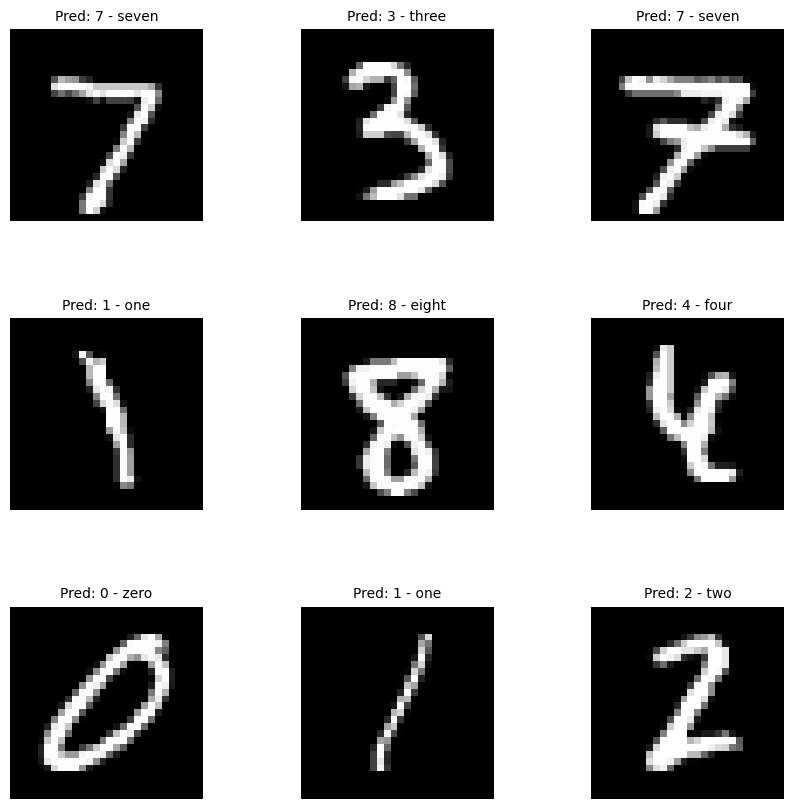

{'model_name': 'LeNet5', 'model_loss': 0.0010499318595975637, 'model_acc': 2.8554313099041533}


In [ ]:
import matplotlib.pyplot as plt

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        # Initialize a counter
        counter = 0
        # Set up the figure for a 3x3 grid
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        # Flatten the axes array for easy indexing
        axes = axes.flatten()
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Visualize the images in a 3x3 grid with their predictions
            if counter < 9:  # Check if the counter is less than 9
                ax = axes[counter]
                ax.imshow(X[0].cpu().squeeze(), cmap='gray')
                ax.axis('off')  # Turn off the axis
                ax.set_title(f"Pred: {class_names[y_pred[0].argmax(dim=0).item()]}", fontsize=10)
                counter += 1  # Increment the counter

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

            # Break the loop if 9 images have been visualized
            if counter >= 9:
                break

        # Show the plot
        plt.show()

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Example usage
model_1_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
print(model_1_results)